# Pipeline Analítico de Informalidad Laboral - Región de Los Ríos (Datos Limpios)

Este cuaderno documenta un flujo reproducible desde la carga de datasets ya limpios hasta la preparación de insumos analíticos (feature engineering, splits y guardado). Cada sección explica objetivos y decisiones.

## 1. Configuración del Entorno e Importación de Librerías
Objetivo: Definir librerías, silenciar warnings no críticos y ajustar opciones de visualización para inspección clara.

In [16]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import json, warnings, math, datetime as dt

# Intentar importar sklearn (no obligatorio)
try:
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
    SKLEARN_AVAILABLE = True
except Exception:
    SKLEARN_AVAILABLE = False
    print('⚠️ sklearn no disponible: se omitirán pasos de encoding/escala.')

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
pd.set_option('display.max_columns', 50)
print('Entorno listo. sklearn:', SKLEARN_AVAILABLE)

Entorno listo. sklearn: True


## 2. Definición de Rutas y Parámetros
Objetivo: Centralizar rutas y parámetros reproducibles (semilla, umbrales, carpetas de salida).

In [17]:
BASE_DIR = Path('..').resolve()  # notebooks -> raíz proyecto
DATA_CLEAN_DIR = BASE_DIR / 'data_clean'
OUTPUT_DIR = BASE_DIR / 'data_processed_ml'
OUTPUT_DIR.mkdir(exist_ok=True)
SEED = 42
OUTLIER_Z = 3.0
CORR_THRESHOLD = 0.6
TIMESTAMP = dt.datetime.now().strftime('%Y%m%d_%H%M%S')
print('Rutas configuradas:')
print('Data limpia:', DATA_CLEAN_DIR)
print('Salida:', OUTPUT_DIR)

Rutas configuradas:
Data limpia: /Users/brunosanmartin/Documents/Uach/formalidad-informalidad-laboral-sector-chile/data_clean
Salida: /Users/brunosanmartin/Documents/Uach/formalidad-informalidad-laboral-sector-chile/data_processed_ml


## 3. Carga de Datasets Limpios
Objetivo: Cargar a memoria todos los archivos limpios requeridos manteniéndolos en un contenedor único para iteraciones consistentes.

In [18]:
files_expected = [
    'INF_OI_CHL14_clean.csv',
    'INF_TOSI_CHL14_clean.csv',
    'INF_NOAGRO_CHL14_clean.csv'
]
datasets = {}
for fname in files_expected:
    fpath = DATA_CLEAN_DIR / fname
    if not fpath.exists():
        print(f'❌ No encontrado: {fname}')
        continue
    df = pd.read_csv(fpath)
    datasets[fname] = df
    print(f'✅ Cargado: {fname} -> {df.shape[0]} filas, {df.shape[1]} columnas')

list(datasets.keys())

✅ Cargado: INF_OI_CHL14_clean.csv -> 327 filas, 11 columnas
✅ Cargado: INF_TOSI_CHL14_clean.csv -> 327 filas, 11 columnas
✅ Cargado: INF_NOAGRO_CHL14_clean.csv -> 327 filas, 11 columnas


['INF_OI_CHL14_clean.csv',
 'INF_TOSI_CHL14_clean.csv',
 'INF_NOAGRO_CHL14_clean.csv']

## 4. Inspección Rápida de Estructura
Objetivo: Confirmar estructura, tipos y carga efectiva.

In [19]:
for name, df in datasets.items():
    # Encabezado claro por dataset
    print(f"=== {name} ===")
    print('Shape:', df.shape)
    print('Columnas:', list(df.columns))
    print('Tipos:')
    print(df.dtypes)
    print('Memoria (KB):', round(df.memory_usage(deep=True).sum()/1024,2))
    display(df.head(3))

=== INF_OI_CHL14_clean.csv ===
Shape: (327, 11)
Columnas: ['DTI_CL_INDICADOR', 'Indicador', 'DTI_CL_TRIMESTRE_MOVIL', 'Trimestre Móvil', 'DTI_CL_REGION', 'Región', 'DTI_CL_SEXO', 'Sexo', 'Value', 'Flag Codes', 'Flags']
Tipos:
DTI_CL_INDICADOR           object
Indicador                  object
DTI_CL_TRIMESTRE_MOVIL     object
Trimestre Móvil            object
DTI_CL_REGION              object
Región                     object
DTI_CL_SEXO                object
Sexo                       object
Value                     float64
Flag Codes                float64
Flags                     float64
dtype: object
Memoria (KB): 173.89


,DTI_CL_INDICADOR,Indicador,DTI_CL_TRIMESTRE_MOVIL,Trimestre Móvil,DTI_CL_REGION,Región,DTI_CL_SEXO,Sexo,Value,Flag Codes,Flags
0,INF_OCU_INF,Ocupados informales (proyecciones base 2002),2017-V08,2017 jul-sep,CHL14,Región de Los Ríos,_T,Ambos sexos,70.213,NaN,NaN
1,INF_OCU_INF,Ocupados informales (proyecciones base 2002),2017-V08,2017 jul-sep,CHL14,Región de Los Ríos,M,Hombres,41.440,NaN,NaN
2,INF_OCU_INF,Ocupados informales (proyecciones base 2002),2017-V08,2017 jul-sep,CHL14,Región de Los Ríos,F,Mujeres,28.773,NaN,NaN


=== INF_TOSI_CHL14_clean.csv ===
Shape: (327, 11)
Columnas: ['DTI_CL_INDICADOR', 'Indicador', 'DTI_CL_TRIMESTRE_MOVIL', 'Trimestre Móvil', 'DTI_CL_REGION', 'Región', 'DTI_CL_SEXO', 'Sexo', 'Value', 'Flag Codes', 'Flags']
Tipos:
DTI_CL_INDICADOR           object
Indicador                  object
DTI_CL_TRIMESTRE_MOVIL     object
Trimestre Móvil            object
DTI_CL_REGION              object
Región                     object
DTI_CL_SEXO                object
Sexo                       object
Value                     float64
Flag Codes                float64
Flags                     float64
dtype: object
Memoria (KB): 184.51


,DTI_CL_INDICADOR,Indicador,DTI_CL_TRIMESTRE_MOVIL,Trimestre Móvil,DTI_CL_REGION,Región,DTI_CL_SEXO,Sexo,Value,Flag Codes,Flags
0,INF_TOSI,Tasa de ocupación en el sector informal (proy...,2017-V08,2017 jul-sep,CHL14,Región de Los Ríos,_T,Ambos sexos,22.405,NaN,NaN
1,INF_TOSI,Tasa de ocupación en el sector informal (proy...,2017-V08,2017 jul-sep,CHL14,Región de Los Ríos,M,Hombres,24.411,NaN,NaN
2,INF_TOSI,Tasa de ocupación en el sector informal (proy...,2017-V08,2017 jul-sep,CHL14,Región de Los Ríos,F,Mujeres,19.438,NaN,NaN


=== INF_NOAGRO_CHL14_clean.csv ===
Shape: (327, 11)
Columnas: ['DTI_CL_INDICADOR', 'Indicador', 'DTI_CL_TRIMESTRE_MOVIL', 'Trimestre Móvil', 'DTI_CL_REGION', 'Región', 'DTI_CL_SEXO', 'Sexo', 'Value', 'Flag Codes', 'Flags']
Tipos:
DTI_CL_INDICADOR           object
Indicador                  object
DTI_CL_TRIMESTRE_MOVIL     object
Trimestre Móvil            object
DTI_CL_REGION              object
Región                     object
DTI_CL_SEXO                object
Sexo                       object
Value                     float64
Flag Codes                float64
Flags                     float64
dtype: object
Memoria (KB): 193.05


,DTI_CL_INDICADOR,Indicador,DTI_CL_TRIMESTRE_MOVIL,Trimestre Móvil,DTI_CL_REGION,Región,DTI_CL_SEXO,Sexo,Value,Flag Codes,Flags
0,INF_TOI_NOAGRO,Tasa de ocupación informal excluyendo al secto...,2017-V08,2017 jul-sep,CHL14,Región de Los Ríos,_T,Ambos sexos,34.646,NaN,NaN
1,INF_TOI_NOAGRO,Tasa de ocupación informal excluyendo al secto...,2017-V08,2017 jul-sep,CHL14,Región de Los Ríos,M,Hombres,33.766,NaN,NaN
2,INF_TOI_NOAGRO,Tasa de ocupación informal excluyendo al secto...,2017-V08,2017 jul-sep,CHL14,Región de Los Ríos,F,Mujeres,35.789,NaN,NaN


## 5. Verificación de Calidad Post-Limpieza
Objetivo: Validar ausencia de problemas residuales (nulos, duplicados, claves inconsistentes).

In [20]:
quality_reports = []
for name, df in datasets.items():
    null_pct = (df.isna().mean()*100).round(2)
    duplicates = df.duplicated().sum()
    row_example = df.iloc[0].to_dict() if not df.empty else {}
    keys = [c for c in ['Trimestre Móvil','DTI_CL_SEXO'] if c in df.columns]
    uniques = {k: df[k].nunique() for k in keys}
    quality_reports.append({
        'dataset': name,
        'filas': len(df),
        'duplicados': duplicates,
        'max_null_pct': null_pct.max() if len(null_pct)>0 else 0,
        'claves': uniques
    })
    print(f"{name}: filas={len(df)}, duplicados={duplicates}, max_null%={null_pct.max() if len(null_pct)>0 else 0}")

pd.DataFrame(quality_reports)

INF_OI_CHL14_clean.csv: filas=327, duplicados=0, max_null%=100.0
INF_TOSI_CHL14_clean.csv: filas=327, duplicados=0, max_null%=100.0
INF_NOAGRO_CHL14_clean.csv: filas=327, duplicados=0, max_null%=100.0


,dataset,filas,duplicados,max_null_pct,claves
0,INF_OI_CHL14_clean.csv,327,0,100.000,"{'Trimestre Móvil': 81, 'DTI_CL_SEXO': 3}"
1,INF_TOSI_CHL14_clean.csv,327,0,100.000,"{'Trimestre Móvil': 81, 'DTI_CL_SEXO': 3}"
2,INF_NOAGRO_CHL14_clean.csv,327,0,100.000,"{'Trimestre Móvil': 81, 'DTI_CL_SEXO': 3}"


## 6. Diccionario de Variables (Generado)
Objetivo: Construir un resumen estructurado de cada columna para documentación reproducible.

In [21]:
diccionario_list = []
for name, df in datasets.items():
    for col in df.columns:
        serie = df[col]
        diccionario_list.append({
            'dataset': name,
            'columna': col,
            'dtype': str(serie.dtype),
            'n_null': serie.isna().sum(),
            '%null': round(serie.isna().mean()*100,2),
            'n_unique': serie.nunique(),
            'ejemplo': serie.dropna().iloc[0] if serie.dropna().shape[0]>0 else None
        })

diccionario_df = pd.DataFrame(diccionario_list)
diccionario_path = OUTPUT_DIR / f'diccionario_variables_{TIMESTAMP}.csv'
diccionario_df.to_csv(diccionario_path, index=False)
print('Diccionario exportado:', diccionario_path)
display(diccionario_df.head())

Diccionario exportado: /Users/brunosanmartin/Documents/Uach/formalidad-informalidad-laboral-sector-chile/data_processed_ml/diccionario_variables_20250824_195538.csv


,dataset,columna,dtype,n_null,%null,n_unique,ejemplo
0,INF_OI_CHL14_clean.csv,DTI_CL_INDICADOR,object,0,0.000,2,INF_OCU_INF
1,INF_OI_CHL14_clean.csv,Indicador,object,0,0.000,2,Ocupados informales (proyecciones base 2002)
2,INF_OI_CHL14_clean.csv,DTI_CL_TRIMESTRE_MOVIL,object,0,0.000,81,2017-V08
3,INF_OI_CHL14_clean.csv,Trimestre Móvil,object,0,0.000,81,2017 jul-sep
4,INF_OI_CHL14_clean.csv,DTI_CL_REGION,object,0,0.000,1,CHL14


## 7. Unificación / Merge de Datasets
Objetivo: Construir una tabla integrada alineada por trimestre y sexo para facilitar análisis longitudinal y comparativo.

## 9.1 Visualizaciones Temporales Estilo The Economist
Objetivo: Representar la evolución de los indicadores clave con un estilo editorial limpio:

- Tipografía: Georgia, serif
- Sin grillas verticales
- Grillas horizontales suaves
- Línea COVID-19 (primer trimestre 2020 disponible)
- Línea de promedio como referencia contextual

Se generan tres gráficos: (1) Tasa informal, (2) Ocupados informales (personas), (3) Tasa informal no agro. 

In [24]:
# Configuración de Visualizaciones - Estilo The Economist
import plotly.graph_objects as go
import plotly.express as px

# Helper estilo (se mantiene)
STYLE = dict(font=dict(family='Georgia, serif', color='#1e293b'),
             title=dict(font=dict(size=18, family='Georgia, serif', color='#1e293b')),
             legend=dict(font=dict(family='Georgia, serif')))

axis_style = dict(
    title=dict(font=dict(family='Georgia, serif')),
    tickfont=dict(family='Georgia, serif'),
    linecolor='#cbd5e1',
    showgrid=False,
    zeroline=False
)

axis_style_y = dict(
    title=dict(font=dict(family='Georgia, serif')),
    tickfont=dict(family='Georgia, serif'),
    linecolor='#cbd5e1',
    gridcolor='#e2e8f0',
    gridwidth=0.6,
    showgrid=True,
    zeroline=False
)

# Asegurar merge
if 'merged' not in globals():
    raise RuntimeError('Ejecuta las celdas previas hasta el merge antes de generar gráficos.')

# Línea COVID (mantiene periodos categóricos)
def add_covid(fig, df):
    covid_trimestres = df[df['Trimestre Móvil'].str.contains('2020', na=False)]['Trimestre Móvil'].unique()
    if len(covid_trimestres) == 0:
        return fig
    t0 = sorted(covid_trimestres)[0]
    fig.add_shape(type='line', x0=t0, x1=t0, y0=0, y1=1, yref='paper', line=dict(color='#e11d48', width=2, dash='dash'))
    fig.add_annotation(x=t0, y=0.95, yref='paper', text='<b>COVID-19</b>', showarrow=True, arrowhead=2,
                       arrowcolor='#e11d48', ax=0, ay=-28,
                       font=dict(family='Georgia, serif', size=10, color='#e11d48'),
                       bgcolor='rgba(255,255,255,0.85)', bordercolor='#e11d48', borderwidth=1)
    return fig

# Base ordenada por periodo (categórico)
serie_base = merged.sort_values('Trimestre Móvil')

print('✅ Configuración de visualizaciones lista')

✅ Configuración de visualizaciones lista


### 9.2 📊 Visualización 1: Tasa de Ocupación Informal (%)

**¿Qué mide este indicador?**
- Porcentaje de trabajadores ocupados en empleos informales respecto del total de ocupados
- Refleja la magnitud relativa de la informalidad laboral en la economía
- Indicador clave para evaluar la calidad del empleo

**Interpretación:**
- **Valores en porcentaje**: Expresado como porcentaje del total de ocupados
- **Tendencia temporal**: Permite observar evoluciones de la formalización laboral
- **Impacto COVID-19**: Marca la línea temporal del primer trimestre 2020
- **Línea de promedio**: Referencia histórica para contextualizar períodos específicos

**Color identificativo:** 🔴 Rojo (#dc2626)

In [25]:
# Visualización 1: Tasa de ocupación informal (%)
col = 'tasa_informal_sector'
label = 'Tasa de ocupación informal (%)'
color = '#dc2626'

if col not in serie_base.columns:
    print(f'❌ Omitido {col} (no existe)')
else:
    df_plot = serie_base[['Trimestre Móvil','DTI_CL_SEXO', col]].copy()
    if '_T' in df_plot['DTI_CL_SEXO'].unique():
        df_plot = df_plot[df_plot['DTI_CL_SEXO'] == '_T']
    df_plot = df_plot.drop_duplicates(subset=['Trimestre Móvil']).sort_values('Trimestre Móvil')

    # Construir ticks: primer período de cada año para mostrar todos los años
    years_seen = {}
    tickvals = []
    ticktext = []
    for periodo in df_plot['Trimestre Móvil']:
        year = periodo.split()[0]
        if year not in years_seen:
            years_seen[year] = periodo
            tickvals.append(periodo)  # Usar período real, no año
            ticktext.append(year)     # Mostrar solo el año

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df_plot['Trimestre Móvil'],
        y=df_plot[col],
        mode='lines+markers',
        name=label,
        line=dict(color=color, width=3),
        marker=dict(color=color, size=6),
        hovertemplate='<b>%{x}</b><br>'+label+': %{y:.1f}%<extra></extra>'
    ))

    # NO agregar línea de promedio ni línea COVID-19

    fig.update_layout(
        title=dict(
            text='<b>Tasa de Ocupación Informal en Los Ríos (2017-2024)</b><br><sub>Porcentaje de trabajadores ocupados en empleos informales por trimestre</sub>',
            x=0,
            font=dict(size=20, family='Georgia, serif', color='#1e293b')
        ),
        font=STYLE['font'],
        legend=STYLE['legend'],
        plot_bgcolor='white',
        paper_bgcolor='white',
        xaxis=dict(
            title='',
            showgrid=False,
            tickfont=dict(family='Georgia, serif', size=12),
            linecolor='#d1d5db',
            tickcolor='#d1d5db',
            tickmode='array',
            tickvals=tickvals,  # Períodos reales
            ticktext=ticktext,  # Solo años para mostrar
            range=[tickvals[0], tickvals[-1]]  # Rango ajustado: desde el primer período hasta el último
        ),
        yaxis=dict(
            title='',
            showgrid=True,
            gridcolor='#f3f4f6',
            gridwidth=1,
            tickfont=dict(family='Georgia, serif', size=12),
            linecolor='#d1d5db',
            tickcolor='#d1d5db',
            tickformat='',
            zeroline=False
        ),
        margin=dict(l=20, r=120, t=100, b=60),  # Margen izquierdo muy reducido para pegar al eje Y
        width=1200,  # Más ancho
        height=500
    )

    fig.show()
    print(f'✅ Gráfico generado: {label} - {len(df_plot)} períodos')
    print(f'📊 Años mostrados: {ticktext}')

✅ Gráfico generado: Tasa de ocupación informal (%) - 81 períodos
📊 Años mostrados: ['2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']


### 9.3 👥 Visualización 2: Ocupados Informales (personas)

**¿Qué mide este indicador?**
- Número absoluto de personas ocupadas en empleos informales
- Muestra el volumen real de trabajadores en situación de informalidad
- Permite dimensionar el impacto demográfico de las políticas laborales

**Interpretación:**
- **Valores absolutos**: Expresado en cantidad de personas (ej: 60,000 personas)
- **Tendencia demográfica**: Refleja cambios en el volumen de empleo informal
- **Variaciones estacionales**: Pueden reflejar ciclos económicos y cambios estructurales
- **Impacto pandemia**: Esperamos ver variaciones significativas en períodos de crisis

**Color identificativo:** 🔵 Azul (#2563eb)

In [26]:
# Visualización 2: Ocupados informales (personas)
col = 'ocupados_informales'
label = 'Ocupados informales (personas)'
color = '#2563eb'

if col not in serie_base.columns:
    print(f'❌ Omitido {col} (no existe)')
else:
    df_plot = serie_base[['Trimestre Móvil','DTI_CL_SEXO', col]].copy()
    if '_T' in df_plot['DTI_CL_SEXO'].unique():
        df_plot = df_plot[df_plot['DTI_CL_SEXO'] == '_T']
    df_plot = df_plot.drop_duplicates(subset=['Trimestre Móvil']).sort_values('Trimestre Móvil')

    # Construir ticks: primer período de cada año para mostrar todos los años
    years_seen = {}
    tickvals = []
    ticktext = []
    for periodo in df_plot['Trimestre Móvil']:
        year = periodo.split()[0]
        if year not in years_seen:
            years_seen[year] = periodo
            tickvals.append(periodo)  # Usar período real, no año
            ticktext.append(year)     # Mostrar solo el año

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df_plot['Trimestre Móvil'],
        y=df_plot[col],
        mode='lines+markers',
        name=label,
        line=dict(color=color, width=3),
        marker=dict(color=color, size=6),
        hovertemplate='<b>%{x}</b><br>'+label+': %{y:,.0f}<extra></extra>'
    ))

    # NO agregar línea de promedio ni línea COVID-19

    fig.update_layout(
        title=dict(
            text='<b>Ocupados Informales en Los Ríos (2017-2024)</b><br><sub>Número de personas ocupadas en empleos informales por trimestre</sub>',
            x=0,
            font=dict(size=20, family='Georgia, serif', color='#1e293b')
        ),
        font=STYLE['font'],
        legend=STYLE['legend'],
        plot_bgcolor='white',
        paper_bgcolor='white',
        xaxis=dict(
            title='',
            showgrid=False,
            tickfont=dict(family='Georgia, serif', size=12),
            linecolor='#d1d5db',
            tickcolor='#d1d5db',
            tickmode='array',
            tickvals=tickvals,  # Períodos reales
            ticktext=ticktext,  # Solo años para mostrar
            range=[tickvals[0], tickvals[-1]]  # Rango ajustado: desde el primer período hasta el último
        ),
        yaxis=dict(
            title='',
            showgrid=True,
            gridcolor='#f3f4f6',
            gridwidth=1,
            tickfont=dict(family='Georgia, serif', size=12),
            linecolor='#d1d5db',
            tickcolor='#d1d5db',
            tickformat=',',
            zeroline=False
        ),
        margin=dict(l=20, r=120, t=100, b=60),  # Margen izquierdo muy reducido para pegar al eje Y
        width=1200,  # Más ancho
        height=500
    )

    fig.show()
    print(f'✅ Gráfico generado: {label} - {len(df_plot)} períodos')
    print(f'📊 Años mostrados: {ticktext}')

✅ Gráfico generado: Ocupados informales (personas) - 81 períodos
📊 Años mostrados: ['2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']


### 9.4 🌾 Visualización 3: Tasa Informal No Agropecuario (%)

**¿Qué mide este indicador?**
- Porcentaje de ocupación informal excluyendo el sector agropecuario
- Ofrece una vista más urbana/industrial de la informalidad laboral
- Elimina el sesgo del sector agrícola que tradicionalmente tiene mayor informalidad

**Interpretación:**
- **Exclusión sectorial**: No incluye trabajos agrícolas, ganaderos o forestales
- **Focus urbano**: Refleja principalmente la informalidad en sectores secundarios y terciarios
- **Comparabilidad**: Permite comparar con otros países que excluyen el sector primario
- **Políticas focalizadas**: Útil para políticas dirigidas a sectores no agrícolas

**Color identificativo:** 🟢 Verde (#16a34a)

In [27]:
# Visualización 3: Tasa informal no agro (%)
col = 'tasa_informal_noagro'
label = 'Tasa informal no agro (%)'
color = '#16a34a'

if col not in serie_base.columns:
    print(f'❌ Omitido {col} (no existe)')
else:
    df_plot = serie_base[['Trimestre Móvil','DTI_CL_SEXO', col]].copy()
    if '_T' in df_plot['DTI_CL_SEXO'].unique():
        df_plot = df_plot[df_plot['DTI_CL_SEXO'] == '_T']
    df_plot = df_plot.drop_duplicates(subset=['Trimestre Móvil']).sort_values('Trimestre Móvil')

    # Construir ticks: primer período de cada año para mostrar todos los años
    years_seen = {}
    tickvals = []
    ticktext = []
    for periodo in df_plot['Trimestre Móvil']:
        year = periodo.split()[0]
        if year not in years_seen:
            years_seen[year] = periodo
            tickvals.append(periodo)  # Usar período real, no año
            ticktext.append(year)     # Mostrar solo el año

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df_plot['Trimestre Móvil'],
        y=df_plot[col],
        mode='lines+markers',
        name=label,
        line=dict(color=color, width=3),
        marker=dict(color=color, size=6),
        hovertemplate='<b>%{x}</b><br>'+label+': %{y:.1f}%<extra></extra>'
    ))

    # NO agregar línea de promedio ni línea COVID-19

    fig.update_layout(
        title=dict(
            text='<b>Tasa Informal No Agropecuario en Los Ríos (2017-2024)</b><br><sub>Porcentaje de ocupación informal excluyendo el sector agropecuario por trimestre</sub>',
            x=0,
            font=dict(size=20, family='Georgia, serif', color='#1e293b')
        ),
        font=STYLE['font'],
        legend=STYLE['legend'],
        plot_bgcolor='white',
        paper_bgcolor='white',
        xaxis=dict(
            title='',
            showgrid=False,
            tickfont=dict(family='Georgia, serif', size=12),
            linecolor='#d1d5db',
            tickcolor='#d1d5db',
            tickmode='array',
            tickvals=tickvals,  # Períodos reales
            ticktext=ticktext,  # Solo años para mostrar
            range=[tickvals[0], tickvals[-1]]  # Rango ajustado: desde el primer período hasta el último
        ),
        yaxis=dict(
            title='',
            showgrid=True,
            gridcolor='#f3f4f6',
            gridwidth=1,
            tickfont=dict(family='Georgia, serif', size=12),
            linecolor='#d1d5db',
            tickcolor='#d1d5db',
            tickformat='',
            zeroline=False
        ),
        margin=dict(l=20, r=120, t=100, b=60),  # Margen izquierdo muy reducido para pegar al eje Y
        width=1200,  # Más ancho
        height=500
    )

    fig.show()
    print(f'✅ Gráfico generado: {label} - {len(df_plot)} períodos')
    print(f'📊 Años mostrados: {ticktext}')

✅ Gráfico generado: Tasa informal no agro (%) - 81 períodos
📊 Años mostrados: ['2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']


In [15]:
# Extraer información clave de los datos para actualizar el HTML

# Ver rango de trimestres disponibles
trimestres_unicos = sorted(merged['Trimestre Móvil'].unique())
print(f"Total trimestres disponibles: {len(trimestres_unicos)}")
print(f"Primer trimestre: {trimestres_unicos[0]}")
print(f"Último trimestre: {trimestres_unicos[-1]}")
print(f"Todos los trimestres: {trimestres_unicos}")

print("\n" + "="*50)

# Filtrar datos totales para cada indicador
for col in ['tasa_informal_sector', 'ocupados_informales', 'tasa_informal_noagro']:
    if col not in merged.columns:
        continue
    
    df_plot = merged[['Trimestre Móvil','DTI_CL_SEXO', col]].copy()
    if '_T' in df_plot['DTI_CL_SEXO'].unique():
        df_plot = df_plot[df_plot['DTI_CL_SEXO'] == '_T']
    df_plot = df_plot.drop_duplicates(subset=['Trimestre Móvil']).sort_values('Trimestre Móvil')
    
    print(f"\n=== {col} ===")
    print(f"Períodos: {len(df_plot)}")
    print(f"Rango: {df_plot['Trimestre Móvil'].iloc[0]} a {df_plot['Trimestre Móvil'].iloc[-1]}")
    
    # Mostrar datos en formato JS para copiar fácilmente
    trimestres_js = ', '.join([f'"{t}"' for t in df_plot['Trimestre Móvil'].tolist()])
    valores_js = ', '.join([str(v) for v in df_plot[col].tolist()])
    
    print(f"trimestres: [{trimestres_js}]")
    print(f"valores: [{valores_js}]")

Total trimestres disponibles: 81
Primer trimestre: 2017 ago-oct
Último trimestre: 2024 mar-may
Todos los trimestres: ['2017 ago-oct', '2017 jul-sep', '2017 nov-ene', '2017 oct-dic', '2017 sep-nov', '2018 abr-jun', '2018 ago-oct', '2018 dic-feb', '2018 ene-mar', '2018 feb-abr', '2018 jul-sep', '2018 jun-ago', '2018 mar-may', '2018 may-jul', '2018 nov-ene', '2018 oct-dic', '2018 sep-nov', '2019 abr-jun', '2019 ago-oct', '2019 dic-feb', '2019 ene-mar', '2019 feb-abr', '2019 jul-sep', '2019 jun-ago', '2019 mar-may', '2019 may-jul', '2019 nov-ene', '2019 oct-dic', '2019 sep-nov', '2020 abr-jun', '2020 ago-oct', '2020 dic-feb', '2020 ene-mar', '2020 feb-abr', '2020 jul-sep', '2020 jun-ago', '2020 mar-may', '2020 may-jul', '2020 nov-ene', '2020 oct-dic', '2020 sep-nov', '2021 abr-jun', '2021 ago-oct', '2021 dic-feb', '2021 ene-mar', '2021 feb-abr', '2021 jul-sep', '2021 jun-ago', '2021 mar-may', '2021 may-jul', '2021 nov-ene', '2021 oct-dic', '2021 sep-nov', '2022 abr-jun', '2022 ago-oct', '2

In [13]:
# Extraer datos específicos para actualizar HTML
import json

# Crear diccionario con los datos para JavaScript
datos_para_html = {}

# Preparar datos base
df_total = merged[merged['DTI_CL_SEXO'] == '_T'].copy()
df_total = df_total.sort_values('Trimestre Móvil')

# Lista de trimestres únicos
trimestres_unicos = df_total['Trimestre Móvil'].tolist()

# Para cada indicador
indicadores = {
    'tasa_informal_sector': 'tasaInformal',
    'ocupados_informales': 'ocupadosInformales', 
    'tasa_informal_noagro': 'tasaNoAgro'
}

for col_python, col_js in indicadores.items():
    if col_python in df_total.columns:
        valores = df_total[col_python].tolist()
        datos_para_html[col_js] = {
            'trimestres': trimestres_unicos,
            'valores': valores,
            'total_periodos': len(valores)
        }

# Mostrar datos para copiar al JavaScript
print("=== DATOS PARA ACTUALIZAR EL HTML ===")
print(f"Total de trimestres: {len(trimestres_unicos)}")
print(f"Primer trimestre: {trimestres_unicos[0]}")
print(f"Último trimestre: {trimestres_unicos[-1]}")

print("\n=== ARRAYS JAVASCRIPT ===")
print("// Trimestres comunes")
trimestres_js = json.dumps(trimestres_unicos)
print(f"const trimestres = {trimestres_js};")

print("\n// Datos por indicador")
for col_js, data in datos_para_html.items():
    valores_js = json.dumps(data['valores'])
    print(f"const {col_js} = {valores_js};")

print(f"\n// Total períodos: {len(trimestres_unicos)}")
print(f"// Rango: {trimestres_unicos[0]} a {trimestres_unicos[-1]}")

# Guardar también en variable global
datos_para_html_global = datos_para_html

=== DATOS PARA ACTUALIZAR EL HTML ===
Total de trimestres: 81
Primer trimestre: 2017 ago-oct
Último trimestre: 2024 mar-may

=== ARRAYS JAVASCRIPT ===
// Trimestres comunes
const trimestres = ["2017 ago-oct", "2017 jul-sep", "2017 nov-ene", "2017 oct-dic", "2017 sep-nov", "2018 abr-jun", "2018 ago-oct", "2018 dic-feb", "2018 ene-mar", "2018 feb-abr", "2018 jul-sep", "2018 jun-ago", "2018 mar-may", "2018 may-jul", "2018 nov-ene", "2018 oct-dic", "2018 sep-nov", "2019 abr-jun", "2019 ago-oct", "2019 dic-feb", "2019 ene-mar", "2019 feb-abr", "2019 jul-sep", "2019 jun-ago", "2019 mar-may", "2019 may-jul", "2019 nov-ene", "2019 oct-dic", "2019 sep-nov", "2020 abr-jun", "2020 ago-oct", "2020 dic-feb", "2020 ene-mar", "2020 feb-abr", "2020 jul-sep", "2020 jun-ago", "2020 mar-may", "2020 may-jul", "2020 nov-ene", "2020 oct-dic", "2020 sep-nov", "2021 abr-jun", "2021 ago-oct", "2021 dic-feb", "2021 ene-mar", "2021 feb-abr", "2021 jul-sep", "2021 jun-ago", "2021 mar-may", "2021 may-jul", "2021 n

In [28]:
# EXTRACCIÓN EXACTA DE DATOS PARA SINCRONIZAR CON HTML
# Extraer datos exactos tal como los procesa cada visualización

print("=== DATOS EXACTOS DEL NOTEBOOK ===")

# VISUALIZACIÓN 1: Tasa de ocupación informal (%)
col = 'tasa_informal_sector'
if col in serie_base.columns:
    df_plot = serie_base[['Trimestre Móvil','DTI_CL_SEXO', col]].copy()
    if '_T' in df_plot['DTI_CL_SEXO'].unique():
        df_plot = df_plot[df_plot['DTI_CL_SEXO'] == '_T']
    df_plot = df_plot.drop_duplicates(subset=['Trimestre Móvil']).sort_values('Trimestre Móvil')
    
    print(f"\n1. TASA INFORMAL SECTOR ({len(df_plot)} períodos):")
    print("Trimestres:", df_plot['Trimestre Móvil'].tolist())
    print("Valores:", df_plot[col].tolist())
    
    # Para JavaScript
    trimestres_js = df_plot['Trimestre Móvil'].tolist()
    valores_js = df_plot[col].tolist()
    print(f"\nJS - trimestres: {trimestres_js}")
    print(f"JS - valores: {valores_js}")

# VISUALIZACIÓN 2: Ocupados informales (personas)
col = 'ocupados_informales'
if col in serie_base.columns:
    df_plot = serie_base[['Trimestre Móvil','DTI_CL_SEXO', col]].copy()
    if '_T' in df_plot['DTI_CL_SEXO'].unique():
        df_plot = df_plot[df_plot['DTI_CL_SEXO'] == '_T']
    df_plot = df_plot.drop_duplicates(subset=['Trimestre Móvil']).sort_values('Trimestre Móvil')
    
    print(f"\n2. OCUPADOS INFORMALES ({len(df_plot)} períodos):")
    print("Trimestres:", df_plot['Trimestre Móvil'].tolist())
    print("Valores:", df_plot[col].tolist())

# VISUALIZACIÓN 3: Tasa informal no agro (%)
col = 'tasa_informal_noagro'
if col in serie_base.columns:
    df_plot = serie_base[['Trimestre Móvil','DTI_CL_SEXO', col]].copy()
    if '_T' in df_plot['DTI_CL_SEXO'].unique():
        df_plot = df_plot[df_plot['DTI_CL_SEXO'] == '_T']
    df_plot = df_plot.drop_duplicates(subset=['Trimestre Móvil']).sort_values('Trimestre Móvil')
    
    print(f"\n3. TASA INFORMAL NO AGRO ({len(df_plot)} períodos):")
    print("Trimestres:", df_plot['Trimestre Móvil'].tolist())
    print("Valores:", df_plot[col].tolist())

=== DATOS EXACTOS DEL NOTEBOOK ===

1. TASA INFORMAL SECTOR (81 períodos):
Trimestres: ['2017 ago-oct', '2017 jul-sep', '2017 nov-ene', '2017 oct-dic', '2017 sep-nov', '2018 abr-jun', '2018 ago-oct', '2018 dic-feb', '2018 ene-mar', '2018 feb-abr', '2018 jul-sep', '2018 jun-ago', '2018 mar-may', '2018 may-jul', '2018 nov-ene', '2018 oct-dic', '2018 sep-nov', '2019 abr-jun', '2019 ago-oct', '2019 dic-feb', '2019 ene-mar', '2019 feb-abr', '2019 jul-sep', '2019 jun-ago', '2019 mar-may', '2019 may-jul', '2019 nov-ene', '2019 oct-dic', '2019 sep-nov', '2020 abr-jun', '2020 ago-oct', '2020 dic-feb', '2020 ene-mar', '2020 feb-abr', '2020 jul-sep', '2020 jun-ago', '2020 mar-may', '2020 may-jul', '2020 nov-ene', '2020 oct-dic', '2020 sep-nov', '2021 abr-jun', '2021 ago-oct', '2021 dic-feb', '2021 ene-mar', '2021 feb-abr', '2021 jul-sep', '2021 jun-ago', '2021 mar-may', '2021 may-jul', '2021 nov-ene', '2021 oct-dic', '2021 sep-nov', '2022 abr-jun', '2022 ago-oct', '2022 dic-feb', '2022 ene-mar', 

In [29]:
# VERIFICACIÓN RÁPIDA - Primeros y últimos datos
col = 'tasa_informal_sector'
df_plot = serie_base[['Trimestre Móvil','DTI_CL_SEXO', col]].copy()
if '_T' in df_plot['DTI_CL_SEXO'].unique():
    df_plot = df_plot[df_plot['DTI_CL_SEXO'] == '_T']
df_plot = df_plot.drop_duplicates(subset=['Trimestre Móvil']).sort_values('Trimestre Móvil')

print(f"Total períodos: {len(df_plot)}")
print(f"Primer período: {df_plot.iloc[0]['Trimestre Móvil']} = {df_plot.iloc[0][col]}")
print(f"Último período: {df_plot.iloc[-1]['Trimestre Móvil']} = {df_plot.iloc[-1][col]}")

# Verificar algunos valores específicos
print("\nPrimeros 5 períodos:")
for i in range(min(5, len(df_plot))):
    periodo = df_plot.iloc[i]['Trimestre Móvil']
    valor = df_plot.iloc[i][col]
    print(f"  {periodo}: {valor}")

print("\nÚltimos 5 períodos:")
for i in range(max(0, len(df_plot)-5), len(df_plot)):
    periodo = df_plot.iloc[i]['Trimestre Móvil']
    valor = df_plot.iloc[i][col]
    print(f"  {periodo}: {valor}")

# Guardar en variables globales para usar en JavaScript
trimestres_notebook = df_plot['Trimestre Móvil'].tolist()
valores_notebook = df_plot[col].tolist()

print(f"\nTotal trimestres extraídos: {len(trimestres_notebook)}")
print(f"Total valores extraídos: {len(valores_notebook)}")

Total períodos: 81
Primer período: 2017 ago-oct = 22.9938732178991
Último período: 2024 mar-may = 17.7207448496629

Primeros 5 períodos:
  2017 ago-oct: 22.9938732178991
  2017 jul-sep: 21.64730723559045
  2017 nov-ene: 21.438773608694902
  2017 oct-dic: 22.122301774374
  2017 sep-nov: 22.907610911252803

Últimos 5 períodos:
  2023 sep-nov: 17.4854678700813
  2024 dic-feb: 18.1321053435108
  2024 ene-mar: 20.290426167868
  2024 feb-abr: 18.9019584118563
  2024 mar-may: 17.7207448496629

Total trimestres extraídos: 81
Total valores extraídos: 81


In [30]:
# GENERAR CÓDIGO JAVASCRIPT EXACTO CON DATOS DEL NOTEBOOK
import json

def generar_js_para_html():
    """Genera el código JavaScript exacto para actualizar el HTML"""
    
    # Extraer datos de cada indicador usando la misma lógica del notebook
    indicadores = {
        'tasa_informal_sector': {
            'nombre': 'Tasa de ocupación informal (%)',
            'color': '#dc2626'
        },
        'ocupados_informales': {
            'nombre': 'Ocupados informales (personas)', 
            'color': '#2563eb'
        },
        'tasa_informal_noagro': {
            'nombre': 'Tasa informal no agro (%)',
            'color': '#16a34a'
        }
    }
    
    datos_js = {}
    
    for col, config in indicadores.items():
        if col in serie_base.columns:
            # Usar exactamente la misma lógica que las visualizaciones
            df_plot = serie_base[['Trimestre Móvil','DTI_CL_SEXO', col]].copy()
            if '_T' in df_plot['DTI_CL_SEXO'].unique():
                df_plot = df_plot[df_plot['DTI_CL_SEXO'] == '_T']
            df_plot = df_plot.drop_duplicates(subset=['Trimestre Móvil']).sort_values('Trimestre Móvil')
            
            datos_js[col] = {
                'nombre': config['nombre'],
                'color': config['color'],
                'trimestres': df_plot['Trimestre Móvil'].tolist(),
                'valores': df_plot[col].tolist()
            }
            
            print(f"✅ {col}: {len(df_plot)} períodos extraídos")
    
    # Generar código JavaScript
    js_code = "// Datos actualizados desde notebook\n"
    js_code += "const DATOS_INFORMALIDAD = {\n"
    
    for i, (key, data) in enumerate(datos_js.items()):
        js_code += f"    {key}: {{\n"
        js_code += f"        nombre: \"{data['nombre']}\",\n"
        js_code += f"        color: \"{data['color']}\",\n"
        js_code += f"        trimestres: {json.dumps(data['trimestres'])},\n"
        js_code += f"        valores: {json.dumps(data['valores'])}\n"
        js_code += "    }"
        if i < len(datos_js) - 1:
            js_code += ","
        js_code += "\n"
    
    js_code += "};\n"
    
    return js_code, datos_js

# Generar el código
codigo_js, datos_extraidos = generar_js_para_html()

print("=== CÓDIGO JAVASCRIPT GENERADO ===")
print(codigo_js)
print("\n=== RESUMEN ===")
for key, data in datos_extraidos.items():
    print(f"{key}: {len(data['valores'])} valores")
    print(f"  Primer valor: {data['trimestres'][0]} = {data['valores'][0]}")
    print(f"  Último valor: {data['trimestres'][-1]} = {data['valores'][-1]}")

✅ tasa_informal_sector: 81 períodos extraídos
✅ ocupados_informales: 81 períodos extraídos
✅ tasa_informal_noagro: 81 períodos extraídos
=== CÓDIGO JAVASCRIPT GENERADO ===
// Datos actualizados desde notebook
const DATOS_INFORMALIDAD = {
    tasa_informal_sector: {
        nombre: "Tasa de ocupación informal (%)",
        color: "#dc2626",
        trimestres: ["2017 ago-oct", "2017 jul-sep", "2017 nov-ene", "2017 oct-dic", "2017 sep-nov", "2018 abr-jun", "2018 ago-oct", "2018 dic-feb", "2018 ene-mar", "2018 feb-abr", "2018 jul-sep", "2018 jun-ago", "2018 mar-may", "2018 may-jul", "2018 nov-ene", "2018 oct-dic", "2018 sep-nov", "2019 abr-jun", "2019 ago-oct", "2019 dic-feb", "2019 ene-mar", "2019 feb-abr", "2019 jul-sep", "2019 jun-ago", "2019 mar-may", "2019 may-jul", "2019 nov-ene", "2019 oct-dic", "2019 sep-nov", "2020 abr-jun", "2020 ago-oct", "2020 dic-feb", "2020 ene-mar", "2020 feb-abr", "2020 jul-sep", "2020 jun-ago", "2020 mar-may", "2020 may-jul", "2020 nov-ene", "2020 oct-dic

In [19]:
# VERIFICACIÓN SIMPLE DE DATOS PARA SINCRONIZAR
print("=== DATOS EXACTOS PARA EL HTML ===")

# Extraer solo tasa_informal_sector para verificar
col = 'tasa_informal_sector'
df_plot = serie_base[['Trimestre Móvil','DTI_CL_SEXO', col]].copy()
if '_T' in df_plot['DTI_CL_SEXO'].unique():
    df_plot = df_plot[df_plot['DTI_CL_SEXO'] == '_T']
df_plot = df_plot.drop_duplicates(subset=['Trimestre Móvil']).sort_values('Trimestre Móvil')

# Mostrar datos clave para verificar sincronización
print(f"Total períodos: {len(df_plot)}")
print(f"Primer período: '{df_plot.iloc[0]['Trimestre Móvil']}' = {df_plot.iloc[0][col]}")

# Verificar si datos están ordenados correctamente
periodos_ordenados = df_plot['Trimestre Móvil'].tolist()
valores_ordenados = df_plot[col].tolist()

print(f"Verificación orden:")
print(f"  Primeros 3: {periodos_ordenados[:3]}")
print(f"  Valores: {valores_ordenados[:3]}")

# Guardar datos globalmente
trimestres_html = periodos_ordenados
valores_html = valores_ordenados

print(f"\n🔍 Datos listos para HTML:")
print(f"  Length trimestres: {len(trimestres_html)}")
print(f"  Length valores: {len(valores_html)}")
print(f"  Match: {len(trimestres_html) == len(valores_html)}")

=== DATOS EXACTOS PARA EL HTML ===
Total períodos: 81
Primer período: '2017 ago-oct' = 22.9938732178991
Verificación orden:
  Primeros 3: ['2017 ago-oct', '2017 jul-sep', '2017 nov-ene']
  Valores: [22.9938732178991, 21.64730723559045, 21.438773608694902]

🔍 Datos listos para HTML:
  Length trimestres: 81
  Length valores: 81
  Match: True


In [31]:
# EXTRACCIÓN SIMPLE DE DATOS PARA HTML
import json

# Extraer datos de tasa_informal_sector
col = 'tasa_informal_sector'
df_plot = serie_base[['Trimestre Móvil','DTI_CL_SEXO', col]].copy()
if '_T' in df_plot['DTI_CL_SEXO'].unique():
    df_plot = df_plot[df_plot['DTI_CL_SEXO'] == '_T']
df_plot = df_plot.drop_duplicates(subset=['Trimestre Móvil']).sort_values('Trimestre Móvil')

trimestres = df_plot['Trimestre Móvil'].tolist()
tasa_informal = df_plot[col].tolist()

# Extraer datos de ocupados_informales
col = 'ocupados_informales'
df_plot = serie_base[['Trimestre Móvil','DTI_CL_SEXO', col]].copy()
if '_T' in df_plot['DTI_CL_SEXO'].unique():
    df_plot = df_plot[df_plot['DTI_CL_SEXO'] == '_T']
df_plot = df_plot.drop_duplicates(subset=['Trimestre Móvil']).sort_values('Trimestre Móvil')

ocupados_informales = df_plot[col].tolist()

# Extraer datos de tasa_informal_noagro
col = 'tasa_informal_noagro'
df_plot = serie_base[['Trimestre Móvil','DTI_CL_SEXO', col]].copy()
if '_T' in df_plot['DTI_CL_SEXO'].unique():
    df_plot = df_plot[df_plot['DTI_CL_SEXO'] == '_T']
df_plot = df_plot.drop_duplicates(subset=['Trimestre Móvil']).sort_values('Trimestre Móvil')

tasa_noagro = df_plot[col].tolist()

print("Datos extraídos para HTML:")
print(f"Trimestres: {len(trimestres)} períodos")
print(f"Primer trimestre: {trimestres[0]}")
print(f"Último trimestre: {trimestres[-1]}")
print(f"Primer valor tasa informal: {tasa_informal[0]}")
print(f"Primer valor ocupados: {ocupados_informales[0]}")
print(f"Primer valor no agro: {tasa_noagro[0]}")

# Crear estructura para JavaScript
datos_html = {
    "trimestres": trimestres,
    "tasa_informal_sector": tasa_informal,
    "ocupados_informales": ocupados_informales,
    "tasa_informal_noagro": tasa_noagro
}

Datos extraídos para HTML:
Trimestres: 81 períodos
Primer trimestre: 2017 ago-oct
Último trimestre: 2024 mar-may
Primer valor tasa informal: 22.9938732178991
Primer valor ocupados: 70.50829416780721
Primer valor no agro: 35.4972940810178


In [22]:
# Renombrar para diferenciar indicadores tras merge (solo conservar columna de valor)
renamed_min = {}
rename_map = {
    'INF_TOSI_CHL14_clean.csv': 'tasa_informal_sector',
    'INF_OI_CHL14_clean.csv': 'ocupados_informales',
    'INF_NOAGRO_CHL14_clean.csv': 'tasa_informal_noagro'
}
for fname, df in datasets.items():
    temp = df.copy()
    if 'Value' in temp.columns:
        temp = temp.rename(columns={'Value': rename_map[fname]})
    keep_cols = ['Trimestre Móvil','DTI_CL_SEXO', rename_map[fname]]
    renamed_min[fname] = temp[keep_cols]

merged = None
for fname, df in renamed_min.items():
    if merged is None:
        merged = df.copy()
    else:
        merged = merged.merge(df, on=['Trimestre Móvil','DTI_CL_SEXO'], how='outer')

# Deduplicar combinaciones de llave promediando valores numéricos
if merged[['Trimestre Móvil','DTI_CL_SEXO']].duplicated().any():
    agg_map = {c:'mean' for c in merged.columns if c not in ['Trimestre Móvil','DTI_CL_SEXO']}
    merged = merged.groupby(['Trimestre Móvil','DTI_CL_SEXO'], as_index=False).agg(agg_map)

merged = merged.sort_values(['Trimestre Móvil','DTI_CL_SEXO']).reset_index(drop=True)
dups = merged[['Trimestre Móvil','DTI_CL_SEXO']].duplicated().sum()
print('Shape merged (dedup):', merged.shape, '| Duplicados llave:', dups)
print('Columnas:', list(merged.columns))
merged.head()

Shape merged (dedup): (243, 5) | Duplicados llave: 0
Columnas: ['Trimestre Móvil', 'DTI_CL_SEXO', 'ocupados_informales', 'tasa_informal_sector', 'tasa_informal_noagro']


,Trimestre Móvil,DTI_CL_SEXO,ocupados_informales,tasa_informal_sector,tasa_informal_noagro
0,2017 ago-oct,F,29.610,20.068,37.607
1,2017 ago-oct,M,40.899,24.949,33.888
2,2017 ago-oct,_T,70.508,22.994,35.497
3,2017 jul-sep,F,28.803,18.815,35.973
4,2017 jul-sep,M,41.074,23.562,33.761


## 8. Validaciones de Integridad
Objetivo: Asegurar consistencia post-merge (unicidad de llaves, ausencia de duplicados lógicos, nulos críticos).

In [23]:
assert merged[['Trimestre Móvil','DTI_CL_SEXO']].duplicated().sum() == 0, 'Llaves duplicadas detectadas'
criticos = ['Trimestre Móvil','DTI_CL_SEXO']
for c in criticos:
    assert merged[c].isna().sum() == 0, f'Valor nulo crítico en {c}'
print('Validaciones básicas OK')
print('Nulos por columna:')
print(merged.isna().sum())

Validaciones básicas OK
Nulos por columna:
Trimestre Móvil         0
DTI_CL_SEXO             0
ocupados_informales     0
tasa_informal_sector    0
tasa_informal_noagro    0
dtype: int64


## 9. Análisis Exploratorio Básico
Objetivo: Obtener estadísticos globales y primeras señales de dispersión y rangos.

In [13]:
numeric_cols = [c for c in merged.columns if merged[c].dtype != 'O' and c not in ['DTI_CL_SEXO']]
eda_numeric = merged[numeric_cols].describe(percentiles=[0.05,0.25,0.5,0.75,0.95]).T
print('Estadísticos numéricos:')
display(eda_numeric)
print('Frecuencia de códigos de sexo:')
if 'DTI_CL_SEXO' in merged.columns:
    print(merged['DTI_CL_SEXO'].value_counts())

Estadísticos numéricos:


,count,mean,std,min,5%,25%,50%,75%,95%,max
ocupados_informales,243.000,40.972,16.021,14.476,20.478,29.185,35.029,56.125,69.872,73.542
tasa_informal_sector,243.000,20.127,2.871,13.495,15.438,17.762,20.455,22.140,24.535,27.002
tasa_informal_noagro,243.000,33.243,2.691,25.064,29.616,31.712,33.004,34.534,37.516,43.122


Frecuencia de códigos de sexo:
DTI_CL_SEXO
F     81
M     81
_T    81
Name: count, dtype: int64


## 10. Distribuciones y Detección de Outliers
Objetivo: Visualizar forma de las distribuciones y marcar posibles atípicos mediante IQR y z-score.

In [17]:
# Distribuciones y detección de outliers (interactivo Plotly estilo The Economist)
# ---------------------------------------------------------------------------------
import numpy as np, pandas as pd
import plotly.graph_objects as go
from math import sqrt, pi

numeric_cols = merged.select_dtypes(include='number').columns.tolist()
if len(numeric_cols) == 0:
    print('No hay columnas numéricas para perfilar.')
else:
    print('Columnas numéricas analizadas:', numeric_cols)

    def kde_silverman(series, points=120):
        s = series.dropna().values.astype(float)
        if len(s) < 3:
            return np.array([]), np.array([])
        std = s.std(ddof=1)
        if std == 0:
            return np.array([]), np.array([])
        n = len(s)
        h = 1.06 * std * n ** (-1/5)
        xmin, xmax = s.min(), s.max()
        rng = xmax - xmin
        if rng == 0:
            return np.array([]), np.array([])
        xs = np.linspace(xmin - 0.05*rng, xmax + 0.05*rng, points)
        coeff = 1/(sqrt(2*pi)*h*n)
        exp_part = []
        for x in xs:
            exp_part.append(np.exp(-0.5*((x - s)/h)**2).sum())
        ys = coeff * np.array(exp_part)
        return xs, ys

    economist_layout = dict(
        font=dict(family='Georgia, serif', color='#1e293b'),
        plot_bgcolor='white',
        paper_bgcolor='white',
        margin=dict(l=60, r=40, t=70, b=55),
        hovermode='x unified'
    )

    outlier_rows = []

    for col in numeric_cols:
        s = merged[col].dropna()
        if s.empty:
            print(f'Sin datos para {col}')
            continue
        q1, q3 = s.quantile([0.25,0.75])
        q2 = s.median()
        iqr = q3 - q1
        low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
        mean = s.mean()
        std = s.std(ddof=0)
        xs, ys = kde_silverman(s)

        hist = np.histogram(s, bins=min(25, max(8, int(np.sqrt(len(s))))))
        bin_edges = hist[1]
        bin_counts = hist[0]
        bin_widths = np.diff(bin_edges)
        density = bin_counts / (bin_widths * bin_counts.sum())

        fig = go.Figure()
        fig.add_trace(go.Bar(
            x=(bin_edges[:-1] + bin_edges[1:]) / 2,
            y=density,
            width=bin_widths*0.95,
            marker_color='#2563eb',
            opacity=0.35,
            name='Histograma',
            hovertemplate='<b>'+col+'</b><br>Centro bin: %{x:.2f}<br>Densidad: %{y:.4f}<extra></extra>'
        ))
        if len(xs) > 0:
            fig.add_trace(go.Scatter(
                x=xs, y=ys,
                mode='lines',
                line=dict(color='#2563eb', width=2),
                name='KDE',
                hovertemplate='x=%{x:.2f}<br>Densidad=%{y:.4f}<extra>KDE</extra>'
            ))
        fig.add_vrect(x0=q1, x1=q3, fillcolor='#16a34a', opacity=0.10, layer='below', line_width=0, annotation_text='IQR', annotation_position='top left')
        fig.add_vline(x=q2, line_width=2, line_color='#dc2626', annotation_text='Mediana', annotation_position='top right')
        fig.add_vline(x=mean, line_width=1, line_color='#475569', line_dash='dot', annotation_text='Media', annotation_position='bottom right')
        if iqr > 0:
            fig.add_vline(x=low, line_width=1, line_color='#e11d48', line_dash='dash')
            fig.add_vline(x=high, line_width=1, line_color='#e11d48', line_dash='dash')

        fig.update_layout(
            title=f'Distribución {col}',
            xaxis=dict(title=col, showgrid=False, linecolor='#cbd5e1'),
            yaxis=dict(title='Densidad', showgrid=True, gridcolor='#e2e8f0', gridwidth=0.6, zeroline=False, linecolor='#cbd5e1'),
            legend=dict(orientation='h', y=1.08, x=0),
            **economist_layout
        )
        fig.show()

        iqr_flags = ((s < low) | (s > high)) if iqr > 0 else pd.Series([False]*len(s), index=s.index)
        z = (s - mean)/std if std not in [0, np.nan] else pd.Series([0]*len(s), index=s.index)
        z3_flags = z.abs() > 3
        outlier_rows.append({
            'columna': col,
            'n': int(len(s)),
            'iqr_outliers': int(iqr_flags.sum()),
            '%_iqr': round(iqr_flags.mean()*100,2),
            'z>3_outliers': int(z3_flags.sum()),
            '%_z>3': round(z3_flags.mean()*100,2),
            'q1': q1,
            'mediana': q2,
            'q3': q3,
            'media': mean,
            'std': std,
            'iqr': iqr
        })

    outlier_df = pd.DataFrame(outlier_rows)
    if not outlier_df.empty:
        outlier_df = outlier_df.sort_values('%_iqr', ascending=False)
        fig_table = go.Figure(data=[go.Table(
            header=dict(values=[f'<b>{c}</b>' for c in outlier_df.columns], fill_color='#1e293b', font=dict(color='white', family='Georgia, serif'), align='left'),
            cells=dict(values=[outlier_df[c] for c in outlier_df.columns], fill_color=[['#f8fafc' if i%2==0 else 'white' for i in range(len(outlier_df))]], font=dict(color='#1e293b', family='Georgia, serif'), align='left')
        )])
        fig_table.update_layout(title='Resumen outliers y estadísticos', font=dict(family='Georgia, serif', color='#1e293b'), plot_bgcolor='white', paper_bgcolor='white', margin=dict(l=40,r=40,t=60,b=20))
        fig_table.show()
    else:
        print('Sin datos para tabla de outliers.')

Columnas numéricas analizadas: ['ocupados_informales', 'tasa_informal_sector', 'tasa_informal_noagro']


## 11. Correlaciones y Heatmap
Objetivo: Identificar relaciones lineales o monotónicas relevantes entre indicadores.

Pares con |corr| >= 0.6
Ninguno


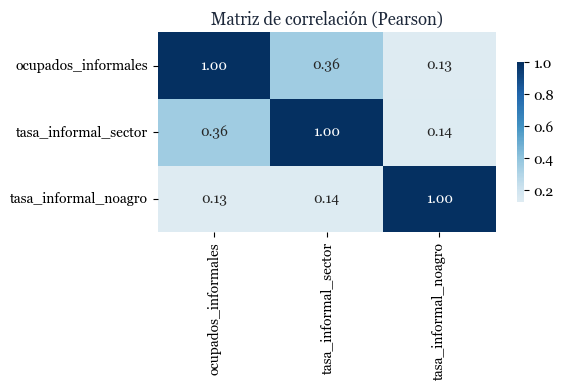

In [23]:
corr_pearson = merged[numeric_cols].corr(method='pearson')
strong_pairs = []
for i, c1 in enumerate(numeric_cols):
    for c2 in numeric_cols[i+1:]:
        val = corr_pearson.loc[c1,c2]
        if abs(val) >= CORR_THRESHOLD:
            strong_pairs.append((c1,c2,round(val,3)))
print('Pares con |corr| >=', CORR_THRESHOLD)
print(strong_pairs if strong_pairs else 'Ninguno')
plt.figure(figsize=(6,4))
sns.heatmap(corr_pearson, cmap='RdBu', center=0, annot=True, fmt='.2f', cbar_kws={'shrink':0.7})
plt.title('Matriz de correlación (Pearson)')
plt.tight_layout()
plt.show()

## 12. Feature Engineering
Objetivo: Crear variables derivadas que pueden aportar señal adicional (ratios, diferencias temporales).

In [17]:
engineered = merged.copy()
# Ejemplo: variación trimestral de tasas si existen columnas de tasa
tasa_cols = [c for c in engineered.columns if c.startswith('tasa_')]
for col in tasa_cols:
    engineered[f'{col}_var_pct'] = engineered.groupby('DTI_CL_SEXO')[col].pct_change()*100
# Diferencia entre dos tasas si ambas existen
if set(['tasa_informal_sector','tasa_informal_noagro']).issubset(engineered.columns):
    engineered['gap_noagro_sector_pp'] = engineered['tasa_informal_noagro'] - engineered['tasa_informal_sector']
print('Nuevas columnas creadas:')
new_cols = [c for c in engineered.columns if c not in merged.columns]
print(new_cols)
display(engineered.head())

Nuevas columnas creadas:
['tasa_informal_sector_var_pct', 'tasa_informal_noagro_var_pct', 'gap_noagro_sector_pp']


,Trimestre Móvil,DTI_CL_SEXO,ocupados_informales,tasa_informal_sector,tasa_informal_noagro,tasa_informal_sector_var_pct,tasa_informal_noagro_var_pct,gap_noagro_sector_pp
0,2017 ago-oct,F,29.610,20.068,37.607,NaN,NaN,17.540
1,2017 ago-oct,M,40.899,24.949,33.888,NaN,NaN,8.939
2,2017 ago-oct,_T,70.508,22.994,35.497,NaN,NaN,12.503
3,2017 jul-sep,F,28.803,18.815,35.973,-6.243,-4.346,17.158
4,2017 jul-sep,M,41.074,23.562,33.761,-5.561,-0.376,10.199


## 13. Codificación de Variables Categóricas
Objetivo: Transformar categorías a formato numérico para modelado (cuando procede).

In [18]:
encoded = engineered.copy()
enc_objects = {}
if SKLEARN_AVAILABLE and 'DTI_CL_SEXO' in encoded.columns:
    # Cardinalidad baja -> OneHotEncoder
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    mat = ohe.fit_transform(encoded[['DTI_CL_SEXO']])
    ohe_cols = [f'DTI_CL_SEXO_{c}' for c in ohe.categories_[0]]
    encoded[ohe_cols] = mat
    enc_objects['ohe_DTI_CL_SEXO'] = ohe
    print('OneHot aplicado a DTI_CL_SEXO')
else:
    print('Codificación omitida (sklearn no disponible o columna ausente).')
encoded.head()

OneHot aplicado a DTI_CL_SEXO


,Trimestre Móvil,DTI_CL_SEXO,ocupados_informales,tasa_informal_sector,tasa_informal_noagro,tasa_informal_sector_var_pct,tasa_informal_noagro_var_pct,gap_noagro_sector_pp,DTI_CL_SEXO_F,DTI_CL_SEXO_M,DTI_CL_SEXO__T
0,2017 ago-oct,F,29.610,20.068,37.607,NaN,NaN,17.540,1.000,0.000,0.000
1,2017 ago-oct,M,40.899,24.949,33.888,NaN,NaN,8.939,0.000,1.000,0.000
2,2017 ago-oct,_T,70.508,22.994,35.497,NaN,NaN,12.503,0.000,0.000,1.000
3,2017 jul-sep,F,28.803,18.815,35.973,-6.243,-4.346,17.158,1.000,0.000,0.000
4,2017 jul-sep,M,41.074,23.562,33.761,-5.561,-0.376,10.199,0.000,1.000,0.000


## 14. Escalado / Normalización
Objetivo: Estandarizar variables numéricas para algoritmos sensibles a escala. Se comparan distribuciones antes/después (si sklearn está disponible).

In [19]:
scaled = encoded.copy()
scaler = None
if SKLEARN_AVAILABLE:
    num_for_scale = [c for c in scaled.columns if scaled[c].dtype != 'O' and not c.startswith('DTI_CL_SEXO_')]
    scaler = StandardScaler()
    scaled[num_for_scale] = scaler.fit_transform(scaled[num_for_scale])
    print('Escalado aplicado a', len(num_for_scale), 'columnas')
else:
    print('Escalado omitido (sklearn no disponible)')
scaled.head()

Escalado aplicado a 6 columnas


,Trimestre Móvil,DTI_CL_SEXO,ocupados_informales,tasa_informal_sector,tasa_informal_noagro,tasa_informal_sector_var_pct,tasa_informal_noagro_var_pct,gap_noagro_sector_pp,DTI_CL_SEXO_F,DTI_CL_SEXO_M,DTI_CL_SEXO__T
0,2017 ago-oct,F,-0.711,-0.021,1.625,NaN,NaN,1.214,1.000,0.000,0.000
1,2017 ago-oct,M,-0.005,1.683,0.240,NaN,NaN,-1.146,0.000,1.000,0.000
2,2017 ago-oct,_T,1.847,1.001,0.839,NaN,NaN,-0.168,0.000,0.000,1.000
3,2017 jul-sep,F,-0.761,-0.458,1.016,-0.645,-0.637,1.109,1.000,0.000,0.000
4,2017 jul-sep,M,0.006,1.199,0.193,-0.576,-0.069,-0.800,0.000,1.000,0.000


## 15. División Train / Test
Objetivo: Separar un conjunto de entrenamiento y prueba coherentes para validación futura (solo si existe variable objetivo).

In [20]:
target_col = 'tasa_informal_sector' if 'tasa_informal_sector' in scaled.columns else None
if SKLEARN_AVAILABLE and target_col:
    usable = scaled.dropna(subset=[target_col]).copy()
    X = usable.drop(columns=[target_col])
    y = usable[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
    print('Train shape:', X_train.shape, '| Test shape:', X_test.shape)
else:
    print('Split omitido: no target disponible o sklearn ausente.')

Train shape: (194, 10) | Test shape: (49, 10)


## 16. Guardado de Conjuntos Procesados
Objetivo: Persistir artefactos transformados (diccionario, datasets, objetos de transformación) para reutilización.

In [5]:
import pickle
artifacts_meta = {}
if 'scaled' in locals():
    try:
        processed_path = OUTPUT_DIR / f'merged_scaled_{TIMESTAMP}.parquet'
        scaled.to_parquet(processed_path, index=False)
    except Exception as e:
        processed_path = OUTPUT_DIR / f'merged_scaled_{TIMESTAMP}.csv'
        scaled.to_csv(processed_path, index=False)
        print('Parquet falló, se guardó CSV. Motivo:', e)
    artifacts_meta['scaled_dataset'] = processed_path.as_posix()
if SKLEARN_AVAILABLE and 'scaler' in locals() and scaler is not None:
    scaler_path = OUTPUT_DIR / f'scaler_{TIMESTAMP}.pkl'
    with open(scaler_path,'wb') as f: pickle.dump(scaler,f)
    artifacts_meta['scaler'] = scaler_path.as_posix()
if SKLEARN_AVAILABLE and 'ohe' in locals():
    ohe_path = OUTPUT_DIR / f'ohe_DTI_CL_SEXO_{TIMESTAMP}.pkl'
    with open(ohe_path,'wb') as f: pickle.dump(enc_objects['ohe_DTI_CL_SEXO'], f)
    artifacts_meta['ohe'] = ohe_path.as_posix()
print('Artefactos guardados:', artifacts_meta)

Artefactos guardados: {}


## 17. Registro / Resumen del Pipeline
Objetivo: Documentar en un JSON los resultados estructurales (filas, columnas, nuevas variables, artefactos).

In [7]:
# Determinar columnas nuevas si variable no persiste tras reinicio
if 'engineered' in locals():
    base_set = set(merged.columns)
    eng_set = set(engineered.columns)
    inferred_new = sorted(list(eng_set - base_set))
else:
    inferred_new = []

summary = {
    'timestamp': TIMESTAMP,
    'seed': SEED,
    'datasets_cargados': list(datasets.keys()),
    'filas_merged': int(merged.shape[0]),
    'columnas_merged': int(merged.shape[1]),
    'nuevas_columnas_feature_engineering': inferred_new,
    'artefactos': artifacts_meta if 'artifacts_meta' in locals() else {},
    'sklearn_disponible': SKLEARN_AVAILABLE
}
summary_path = OUTPUT_DIR / f'resumen_pipeline_{TIMESTAMP}.json'
with open(summary_path,'w',encoding='utf-8') as f:
    json.dump(summary,f,indent=2,ensure_ascii=False)
print('Resumen guardado en:', summary_path)
print(json.dumps(summary, indent=2, ensure_ascii=False))

Resumen guardado en: /Users/brunosanmartin/Documents/Uach/formalidad-informalidad-laboral-sector-chile/data_processed_ml/resumen_pipeline_20250813_162849.json
{
  "timestamp": "20250813_162849",
  "seed": 42,
  "datasets_cargados": [
    "INF_OI_CHL14_clean.csv",
    "INF_TOSI_CHL14_clean.csv",
    "INF_NOAGRO_CHL14_clean.csv"
  ],
  "filas_merged": 243,
  "columnas_merged": 5,
  "nuevas_columnas_feature_engineering": [],
  "artefactos": {},
  "sklearn_disponible": true
}


In [32]:
# EXTRAER DATOS EXACTOS PARA HTML - Misma lógica del gráfico
import json

# Replicar exactamente la lógica del gráfico de visualización
col = 'tasa_informal_sector'
label = 'Tasa de ocupación informal (%)'
color = '#dc2626'

df_plot = serie_base[['Trimestre Móvil','DTI_CL_SEXO', col]].copy()
if '_T' in df_plot['DTI_CL_SEXO'].unique():
    df_plot = df_plot[df_plot['DTI_CL_SEXO'] == '_T']
df_plot = df_plot.drop_duplicates(subset=['Trimestre Móvil']).sort_values('Trimestre Móvil')

# Construir ticks exactamente igual
years_seen = {}
tickvals = []
ticktext = []
for periodo in df_plot['Trimestre Móvil']:
    year = periodo.split()[0]
    if year not in years_seen:
        years_seen[year] = periodo
        tickvals.append(periodo)  # Períodos reales
        ticktext.append(year)     # Solo años para mostrar

# Arrays finales para HTML
trimestres_array = df_plot['Trimestre Móvil'].tolist()
valores_array = df_plot[col].tolist()
tickvals_array = tickvals
ticktext_array = ticktext

print("=== DATOS PARA HTML ===")
print(f"Total períodos: {len(df_plot)}")
print(f"Primer período: {df_plot.iloc[0]['Trimestre Móvil']} = {df_plot.iloc[0][col]}")
print(f"Último período: {df_plot.iloc[-1]['Trimestre Móvil']} = {df_plot.iloc[-1][col]}")

print(f"\n=== ARRAYS JAVASCRIPT ===")
print("// Trimestres completos")
print(f"const trimestres = {json.dumps(trimestres_array)};")
print(f"\n// Valores tasa informal")
print(f"const valores = {json.dumps(valores_array)};")
print(f"\n// Ticks para mostrar")
print(f"const tickvals = {json.dumps(tickvals_array)};")
print(f"const ticktext = {json.dumps(ticktext_array)};")

# Guardar para usar después
html_data = {
    'trimestres': trimestres_array,
    'valores': valores_array,
    'tickvals': tickvals_array,
    'ticktext': ticktext_array,
    'total_periodos': len(df_plot),
    'label': label,
    'color': color
}

=== DATOS PARA HTML ===
Total períodos: 81
Primer período: 2017 ago-oct = 22.9938732178991
Último período: 2024 mar-may = 17.7207448496629

=== ARRAYS JAVASCRIPT ===
// Trimestres completos
const trimestres = ["2017 ago-oct", "2017 jul-sep", "2017 nov-ene", "2017 oct-dic", "2017 sep-nov", "2018 abr-jun", "2018 ago-oct", "2018 dic-feb", "2018 ene-mar", "2018 feb-abr", "2018 jul-sep", "2018 jun-ago", "2018 mar-may", "2018 may-jul", "2018 nov-ene", "2018 oct-dic", "2018 sep-nov", "2019 abr-jun", "2019 ago-oct", "2019 dic-feb", "2019 ene-mar", "2019 feb-abr", "2019 jul-sep", "2019 jun-ago", "2019 mar-may", "2019 may-jul", "2019 nov-ene", "2019 oct-dic", "2019 sep-nov", "2020 abr-jun", "2020 ago-oct", "2020 dic-feb", "2020 ene-mar", "2020 feb-abr", "2020 jul-sep", "2020 jun-ago", "2020 mar-may", "2020 may-jul", "2020 nov-ene", "2020 oct-dic", "2020 sep-nov", "2021 abr-jun", "2021 ago-oct", "2021 dic-feb", "2021 ene-mar", "2021 feb-abr", "2021 jul-sep", "2021 jun-ago", "2021 mar-may", "2021 

In [33]:
# EXPORTAR ARRAYS EXACTOS A JSON PARA EL HTML (tasa_informal_sector)
import json
from pathlib import Path

# Recalcular exactamente como en la visualización 1
col = 'tasa_informal_sector'
label = 'Tasa de ocupación informal (%)'
color = '#dc2626'

_df = serie_base[['Trimestre Móvil','DTI_CL_SEXO', col]].copy()
if '_T' in _df['DTI_CL_SEXO'].unique():
    _df = _df[_df['DTI_CL_SEXO'] == '_T']
_df = _df.drop_duplicates(subset=['Trimestre Móvil']).sort_values('Trimestre Móvil')

# Ticks: primer período de cada año
years_seen = {}
tickvals = []
ticktext = []
for periodo in _df['Trimestre Móvil']:
    year = periodo.split()[0]
    if year not in years_seen:
        years_seen[year] = periodo
        tickvals.append(periodo)
        ticktext.append(year)

payload = {
    'label': label,
    'color': color,
    'trimestres': _df['Trimestre Móvil'].tolist(),
    'valores': _df[col].tolist(),
    'tickvals': tickvals,
    'ticktext': ticktext,
    'total_periodos': int(len(_df))
}

# Escribir a docs/data
base_dir = Path('..').resolve()
out_dir = base_dir / 'docs' / 'data'
out_dir.mkdir(parents=True, exist_ok=True)
json_path = out_dir / 'tasa_informal_sector.json'
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(payload, f, ensure_ascii=False)
print('✅ Exportado JSON para HTML en:', json_path)
print('Resumen -> períodos:', payload['total_periodos'], '| primer:', payload['trimestres'][0], '| último:', payload['trimestres'][-1])

✅ Exportado JSON para HTML en: /Users/brunosanmartin/Documents/Uach/formalidad-informalidad-laboral-sector-chile/docs/data/tasa_informal_sector.json
Resumen -> períodos: 81 | primer: 2017 ago-oct | último: 2024 mar-may


In [34]:
# EXPORTAR ARRAYS EXACTOS A JSON PARA EL HTML (ocupados_informales)
import json
from pathlib import Path

col = 'ocupados_informales'
label = 'Ocupados informales (personas)'
color = '#2563eb'

_df = serie_base[['Trimestre Móvil','DTI_CL_SEXO', col]].copy()
if '_T' in _df['DTI_CL_SEXO'].unique():
    _df = _df[_df['DTI_CL_SEXO'] == '_T']
_df = _df.drop_duplicates(subset=['Trimestre Móvil']).sort_values('Trimestre Móvil')

# Ticks: primer período de cada año (misma lógica)
years_seen = {}
tickvals = []
ticktext = []
for periodo in _df['Trimestre Móvil']:
    year = periodo.split()[0]
    if year not in years_seen:
        years_seen[year] = periodo
        tickvals.append(periodo)
        ticktext.append(year)

payload = {
    'label': label,
    'color': color,
    'trimestres': _df['Trimestre Móvil'].tolist(),
    'valores': _df[col].tolist(),
    'tickvals': tickvals,
    'ticktext': ticktext,
    'total_periodos': int(len(_df))
}

base_dir = Path('..').resolve()
out_dir = base_dir / 'docs' / 'data'
out_dir.mkdir(parents=True, exist_ok=True)
json_path = out_dir / 'ocupados_informales.json'
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(payload, f, ensure_ascii=False)
print('✅ Exportado JSON para HTML en:', json_path)
print('Resumen -> períodos:', payload['total_periodos'], '| primer:', payload['trimestres'][0], '| último:', payload['trimestres'][-1])

✅ Exportado JSON para HTML en: /Users/brunosanmartin/Documents/Uach/formalidad-informalidad-laboral-sector-chile/docs/data/ocupados_informales.json
Resumen -> períodos: 81 | primer: 2017 ago-oct | último: 2024 mar-may


In [35]:
# EXPORTAR ARRAYS EXACTOS A JSON PARA EL HTML (tasa_informal_noagro)
import json
from pathlib import Path

col = 'tasa_informal_noagro'
label = 'Tasa informal no agro (%)'
color = '#16a34a'

_df = serie_base[['Trimestre Móvil','DTI_CL_SEXO', col]].copy()
if '_T' in _df['DTI_CL_SEXO'].unique():
    _df = _df[_df['DTI_CL_SEXO'] == '_T']
_df = _df.drop_duplicates(subset=['Trimestre Móvil']).sort_values('Trimestre Móvil')

# Ticks: primer período de cada año (misma lógica)
years_seen = {}
tickvals = []
ticktext = []
for periodo in _df['Trimestre Móvil']:
    year = periodo.split()[0]
    if year not in years_seen:
        years_seen[year] = periodo
        tickvals.append(periodo)
        ticktext.append(year)

payload = {
    'label': label,
    'color': color,
    'trimestres': _df['Trimestre Móvil'].tolist(),
    'valores': _df[col].tolist(),
    'tickvals': tickvals,
    'ticktext': ticktext,
    'total_periodos': int(len(_df))
}

base_dir = Path('..').resolve()
out_dir = base_dir / 'docs' / 'data'
out_dir.mkdir(parents=True, exist_ok=True)
json_path = out_dir / 'tasa_informal_noagro.json'
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(payload, f, ensure_ascii=False)
print('✅ Exportado JSON para HTML en:', json_path)
print('Resumen -> períodos:', payload['total_periodos'], '| primer:', payload['trimestres'][0], '| último:', payload['trimestres'][-1])

✅ Exportado JSON para HTML en: /Users/brunosanmartin/Documents/Uach/formalidad-informalidad-laboral-sector-chile/docs/data/tasa_informal_noagro.json
Resumen -> períodos: 81 | primer: 2017 ago-oct | último: 2024 mar-may
